### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, pickle, gzip
import gc

In [2]:
import sys
from pathlib import Path
# if notebook is in PMLS_project/notebooks, add PMLS_project
sys.path.insert(0, str(Path.cwd().parent))

## Load data

In [3]:
def load_results(path: str):
    with gzip.open(path, "rb") as f:
        return pickle.load(f)

In [4]:
def find_repo_root(start=None) -> Path:
    p = Path(start or Path.cwd()).resolve()
    for q in (p, *p.parents):
        if (q / ".git").exists():
            return q
    raise RuntimeError("Could not find repo root (no .git found).")

ROOT = find_repo_root()
RUNS = ROOT / "runs"
RUNS.mkdir(exist_ok=True)

In [5]:
ladder_root = str((RUNS/"ladder"/ "smoke_8dpt/results.pkl.gz").resolve())
results_1d = load_results(ladder_root)
betas_t0=results_1d[0].beta_by_t[0]
K_0 = len(betas_t0)
I_ts_t0_stack = np.stack([r.Ψ_ts[:,:,:K_0] for r in results_1d], axis=0)
del results_1d
gc.collect()

47295

In [6]:
ladder_root = str((RUNS/"ladder"/ "smoke_9dpt/results.pkl.gz").resolve())
results_2d = load_results(ladder_root)
beta_by_t = results_2d[0].beta_by_t
I_ts_stack = np.stack([r.Ψ_ts for r in results_2d], axis=0)

del results_2d
gc.collect()

0

## Functions

In [7]:
def pt2d_roundtrip_medians(
    I_ts_stack,
    *,
    k_start,
    hot_mode="all",          # "b0" or "all"
    stat="median",           # "median" or "mean"
    burn_in=0,               # int steps, or float fraction in (0,1)
    chains=(0, 1),           # independent chains to analyze
    show=False,              # default False to avoid lots of figures when called 3x
):
    """
    Round-trip stats on flattened 2D PT graph.

    Input shape:
      I_ts_stack: (R, C, T, N) or (C, T, N) or (T, N)
      where N = k_start[-1] is the flattened node count, and I[t,n] is walker id (0..N-1).

    Endpoints:
      - cold is SINGLE node at b=0: cold = k_start[1]-1
      - hot is either node 0 ("b0") or set k_start[:-1] ("all")

    Returns dict containing both mean & median arrays, plus stat-selected aliases:
      rt_hch, rt_chc correspond to chosen 'stat'.
    """

    I = np.asarray(I_ts_stack)
    if I.ndim == 4:
        R, C, T, N = I.shape
    elif I.ndim == 3:
        R = 1
        C, T, N = I.shape
        I = I[None, ...]
    elif I.ndim == 2:
        R = 1
        C = 1
        T, N = I.shape
        I = I[None, None, ...]
    else:
        raise ValueError("I_ts_stack must have shape (R,C,T,N), (C,T,N), or (T,N).")

    k_start = np.asarray(k_start, dtype=np.int64)
    if k_start.ndim != 1 or k_start.size < 2:
        raise ValueError("k_start must be 1D with at least 2 entries (need b=0 ladder).")
    if int(k_start[-1]) != N:
        raise ValueError(f"k_start[-1]={k_start[-1]} must equal N={N}.")

    if stat not in ("median", "mean"):
        raise ValueError("stat must be 'median' or 'mean'.")

    # burn-in
    if isinstance(burn_in, float):
        if not (0.0 <= burn_in < 1.0):
            raise ValueError("burn_in as float must be in [0,1).")
        t0 = int(np.floor(burn_in * T))
    else:
        t0 = int(burn_in)
    t0 = max(0, min(t0, T - 1))
    Teff = T - t0

    chains = tuple(int(c) for c in chains)
    for c in chains:
        if not (0 <= c < C):
            raise ValueError(f"chain index {c} out of range for C={C}.")

    # endpoints
    cold_node = int(k_start[1] - 1)  # single cold at b=0
    cold_nodes = np.array([cold_node], dtype=np.int64)

    if hot_mode == "b0":
        hot_nodes = np.array([0], dtype=np.int64)
    elif hot_mode == "all":
        hot_nodes = k_start[:-1].astype(np.int64)
    else:
        raise ValueError("hot_mode must be 'b0' or 'all'.")

    def _roundtrips_set(I_bt, hot_nodes, cold_nodes):
        # per-walker state
        tH = np.full(N, -1, dtype=np.int64)
        tC = np.full(N, -1, dtype=np.int64)
        seenC = np.zeros(N, dtype=bool)  # since last hot-start
        seenH = np.zeros(N, dtype=bool)  # since last cold-start

        rts_hch = []
        rts_chc = []

        for t in range(I_bt.shape[0]):
            Wc = I_bt[t, cold_nodes]  # (1,)
            Wh = I_bt[t, hot_nodes]   # (|H|,)

            # cold visits: can close CHC; also arm HCH
            for w in Wc:
                w = int(w)
                if tH[w] != -1:
                    seenC[w] = True
                if tC[w] != -1 and seenH[w]:
                    rts_chc.append(t - tC[w])
                tC[w] = t
                seenH[w] = False

            # hot visits: can close HCH; also arm CHC
            for w in Wh:
                w = int(w)
                if tC[w] != -1:
                    seenH[w] = True
                if tH[w] != -1 and seenC[w]:
                    rts_hch.append(t - tH[w])
                tH[w] = t
                seenC[w] = False

        return rts_hch, rts_chc

    # allocate outputs
    rt_med_hch  = np.full((R, C), np.nan, dtype=float)
    rt_mean_hch = np.full((R, C), np.nan, dtype=float)
    rt_med_chc  = np.full((R, C), np.nan, dtype=float)
    rt_mean_chc = np.full((R, C), np.nan, dtype=float)

    rt_count_hch = np.zeros((R, C), dtype=np.int64)
    rt_count_chc = np.zeros((R, C), dtype=np.int64)
    rt_rate_hch  = np.zeros((R, C), dtype=float)
    rt_rate_chc  = np.zeros((R, C), dtype=float)

    for r in range(R):
        for c in chains:
            I_bt = I[r, c, t0:, :].astype(np.int64)  # (Teff, N)
            rts_hch, rts_chc = _roundtrips_set(I_bt, hot_nodes, cold_nodes)

            rt_count_hch[r, c] = len(rts_hch)
            rt_count_chc[r, c] = len(rts_chc)
            rt_rate_hch[r, c]  = len(rts_hch) / max(1, Teff)
            rt_rate_chc[r, c]  = len(rts_chc) / max(1, Teff)

            if rts_hch:
                a = np.asarray(rts_hch, dtype=np.float64)
                rt_med_hch[r, c]  = float(np.median(a))
                rt_mean_hch[r, c] = float(np.mean(a))

            if rts_chc:
                a = np.asarray(rts_chc, dtype=np.float64)
                rt_med_chc[r, c]  = float(np.median(a))
                rt_mean_chc[r, c] = float(np.mean(a))

    # stat-selected aliases (what the plotter uses)
    if stat == "median":
        rt_hch, rt_chc = rt_med_hch, rt_med_chc
    else:
        rt_hch, rt_chc = rt_mean_hch, rt_mean_chc

    if show:
        xs = np.arange(R)

        def _scatter(rt, title, ylabel):
            plt.figure(figsize=(7, 3.8))
            for c in chains:
                if c == 0:
                    plt.plot(xs, rt[:, c], linestyle="none", marker="o",
                             markerfacecolor="none", markeredgecolor="k", label="chain 0")
                elif c == 1:
                    plt.plot(xs, rt[:, c], linestyle="none", marker="o",
                             markerfacecolor="k", markeredgecolor="k", alpha=0.6, label="chain 1")
                else:
                    plt.plot(xs, rt[:, c], linestyle="none", marker="o", label=f"chain {c}")
            plt.yscale("log")
            plt.xlabel("disorder index r")
            plt.ylabel(ylabel)
            plt.title(title)
            plt.legend()
            plt.tight_layout()

        _scatter(rt_hch, f"{stat} RT: hot→cold→hot (hot_mode={hot_mode}, burn_in={t0})",
                 f"{stat} RT time (steps)")
        _scatter(rt_chc, f"{stat} RT: cold→hot→cold (hot_mode={hot_mode}, burn_in={t0})",
                 f"{stat} RT time (steps)")
        plt.show()

    return dict(
        shape=dict(R=R, C=C, T=T, N=N, burn_in=t0, Teff=Teff),
        hot_mode=hot_mode,
        stat=stat,
        hot_nodes=hot_nodes.copy(),
        cold_node=cold_node,
        # always-returned detailed stats
        rt_med_hch=rt_med_hch,
        rt_mean_hch=rt_mean_hch,
        rt_med_chc=rt_med_chc,
        rt_mean_chc=rt_mean_chc,
        rt_count_hch=rt_count_hch,
        rt_count_chc=rt_count_chc,
        rt_rate_hch=rt_rate_hch,
        rt_rate_chc=rt_rate_chc,
        # stat-selected aliases for plotting
        rt_hch=rt_hch,
        rt_chc=rt_chc,
    )


def compare_roundtrip_times_2x3(
    out1d, out2d_b0, out2d_all,
    *,
    stat="median",              # "median" or "mean"
    chains=(0, 1),
    col_titles=("1D (hot=b0)", "2D (hot=b0)", "2D (hot=all)"),
    row_titles=("hot→cold→hot", "cold→hot→cold"),
    show=True,
):
    """
    2x3 grid:
      row 0: HCH, row 1: CHC
      col 0: out1d, col 1: out2d_b0, col 2: out2d_all
    Uses out["rt_hch"] and out["rt_chc"] (so pass outputs made with the same stat).
    """

    outs = [out1d, out2d_b0, out2d_all]

    if stat not in ("median", "mean"):
        raise ValueError("stat must be 'median' or 'mean'.")

    # prefer stat-selected aliases; fall back to explicit keys if needed
    def _get(out, which):
        if which in out:
            return np.asarray(out[which], float)
        # fallback if someone passes older dicts
        if stat == "median":
            return np.asarray(out["rt_med_hch" if which == "rt_hch" else "rt_med_chc"], float)
        else:
            return np.asarray(out["rt_mean_hch" if which == "rt_hch" else "rt_mean_chc"], float)

    Rs = [_get(o, "rt_hch").shape[0] for o in outs]
    if len(set(Rs)) != 1:
        raise ValueError(f"Different R across outputs: {Rs}")
    R = Rs[0]
    xs = np.arange(R)

    fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharey=True)

    def _plot_one(ax, rt):
        for c in chains:
            if c == 0:
                ax.plot(xs, rt[:, c], linestyle="none", marker="o",
                        markerfacecolor="none", markeredgecolor="k", label="chain 0")
            elif c == 1:
                ax.plot(xs, rt[:, c], linestyle="none", marker="o",
                        markerfacecolor="k", markeredgecolor="k", alpha=0.6, label="chain 1")
            else:
                ax.plot(xs, rt[:, c], linestyle="none", marker="o", label=f"chain {c}")
        ax.set_yscale("log")
        ax.set_xlabel("disorder index r")
        ax.grid(True, which="both", alpha=0.2)

    for j, out in enumerate(outs):
        rt_hch = _get(out, "rt_hch")
        #rt_chc = _get(out, "rt_chc")

        _plot_one(axes[j], rt_hch)
        #_plot_one(axes[1, j], rt_chc)

        axes[j].set_title(col_titles[j])
        if j == 0:
            axes[j].set_ylabel(f"{row_titles[0]}\n{stat} RT time (steps)")
            #axes[1, j].set_ylabel(f"{row_titles[1]}\n{stat} RT time (steps)")

    # one shared legend
    h, l = axes[0].get_legend_handles_labels()
    fig.legend(h, l, loc="upper center", ncol=len(chains), frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    if show:
        plt.show()
    return fig, axes


In [8]:
def empirical_passage_stats(
    I_ts_stack,N,
    *,
    hot_idx,
    cold_idx,
    stride: int = 1,
    burn_in=0,          # int steps, or float fraction in [0,1)
    chains=(0, 1),
    stat="mean",        # "mean" or "median" for tau summaries
):
    """
    Empirical one-way passage stats from permutation time series.

    I_ts_stack: (R, C, T, N) box->walker
    hot_idx, cold_idx: arrays of *node indices* in [0..N-1] (boxes).
                        (Disjoint sets recommended.)
    stride: 1 (micro) or 3 (macro-subsampled). Returned also as dt=stride.

    Returns:
      k_hc, k_ch: (R,C) rates per stride-step
      k_hc_per_tick, k_ch_per_tick: rates per underlying tick
      tau_hc, tau_ch: (R,C) mean/median passage time in stride-steps
      tau_hc_ticks, tau_ch_ticks: same in underlying ticks
      plus counts.
    """
    I = np.asarray(I_ts_stack, dtype=np.int64)
    if I.ndim != 4:
        raise ValueError("I_ts_stack must have shape (R,C,T,N).")
    R, C, T, N = I.shape

    stride = int(max(1, stride))
    dt = stride

    hot_idx = np.asarray(hot_idx, dtype=np.int64)
    cold_idx = np.asarray(cold_idx, dtype=np.int64)
    if np.intersect1d(hot_idx, cold_idx).size:
        raise ValueError("hot_idx and cold_idx overlap.")

    # burn-in
    if isinstance(burn_in, float):
        if not (0.0 <= burn_in < 1.0):
            raise ValueError("burn_in as float must be in [0,1).")
        t0 = int(np.floor(burn_in * T))
    else:
        t0 = int(burn_in)
    t0 = max(0, min(t0, T - 1))

    chains = tuple(int(c) for c in chains)
    for c in chains:
        if not (0 <= c < C):
            raise ValueError(f"chain index {c} out of range for C={C}.")

    # outputs
    k_hc = np.full((R, C), np.nan, float)
    k_ch = np.full((R, C), np.nan, float)
    k_hc_per_tick = np.full((R, C), np.nan, float)
    k_ch_per_tick = np.full((R, C), np.nan, float)

    tau_hc = np.full((R, C), np.nan, float)
    tau_ch = np.full((R, C), np.nan, float)
    tau_hc_ticks = np.full((R, C), np.nan, float)
    tau_ch_ticks = np.full((R, C), np.nan, float)

    n_hc = np.zeros((R, C), np.int64)
    n_ch = np.zeros((R, C), np.int64)

    def _summ(x):
        if len(x) == 0:
            return np.nan
        a = np.asarray(x, float)
        return float(np.mean(a)) if stat == "mean" else float(np.median(a))

    for r in range(R):
        for c in chains:
            I_bt = I[r, c, t0:, :]
            # subsample clock
            I_bt = I_bt[::stride]
            Te = I_bt.shape[0]
            if Te < 2:
                continue

            last_end = np.zeros(N, dtype=np.int8)   # 0 none, +1 hot, -1 cold
            last_t   = np.full(N, -1, dtype=np.int64)

            tau_hc_list = []
            tau_ch_list = []

            for t in range(Te):
                Wc = I_bt[t, cold_idx]  # walkers currently at cold nodes
                Wh = I_bt[t, hot_idx]   # walkers currently at hot nodes

                # cold hits: close H->C if last was hot
                for w in Wc:
                    w = int(w)
                    if last_end[w] == +1 and last_t[w] != -1:
                        tau_hc_list.append(t - last_t[w])
                    last_end[w] = -1
                    last_t[w] = t

                # hot hits: close C->H if last was cold
                for w in Wh:
                    w = int(w)
                    if last_end[w] == -1 and last_t[w] != -1:
                        tau_ch_list.append(t - last_t[w])
                    last_end[w] = +1
                    last_t[w] = t

            n_hc[r, c] = len(tau_hc_list)
            n_ch[r, c] = len(tau_ch_list)

            k_hc[r, c] = n_hc[r, c] / max(1, Te)
            k_ch[r, c] = n_ch[r, c] / max(1, Te)
            k_hc_per_tick[r, c] = k_hc[r, c] / dt
            k_ch_per_tick[r, c] = k_ch[r, c] / dt

            tau_hc[r, c] = _summ(tau_hc_list)
            tau_ch[r, c] = _summ(tau_ch_list)
            tau_hc_ticks[r, c] = tau_hc[r, c] * dt
            tau_ch_ticks[r, c] = tau_ch[r, c] * dt

    return dict(
        kind="empirical",
        stride=stride,
        dt=dt,
        burn_in=t0,
        stat=stat,
        hot_idx=hot_idx.copy(),
        cold_idx=cold_idx.copy(),
        k_hc=k_hc,
        k_ch=k_ch,
        k_hc_per_tick=k_hc_per_tick/ N,
        k_ch_per_tick=k_ch_per_tick/ N,
        tau_hc=tau_hc,
        tau_ch=tau_ch,
        tau_hc_ticks=tau_hc_ticks,
        tau_ch_ticks=tau_ch_ticks,
        n_hc=n_hc,
        n_ch=n_ch,
    )


In [9]:
def plot_rate_hist_overlay(
    out1, out2, *,
    direction="hc",
    per_tick=True,
    chain="mean",          # "mean" or int (0/1)
    bins=30,
    logx=False,
    label1="emp 1",
    label2="emp 2",
    title=None,
):
    """
    Overlay two rate histograms (same quantity) on one axes.

    out1/out2: dicts with keys like k_hc_per_tick or k_hc (empirical or theory-style outputs)
    direction: "hc" or "ch"
    per_tick: True -> use *_per_tick keys
    chain: for (R,2) arrays, average chains or pick chain index
    """

    key = ("k_hc_per_tick" if per_tick else "k_hc") if direction == "hc" else ("k_ch_per_tick" if per_tick else "k_ch")

    def _extract(out):
        x = np.asarray(out[key], float)
        if x.ndim == 2:
            x = np.nanmean(x, axis=1) if chain == "mean" else x[:, int(chain)]
        x = x[np.isfinite(x) & (x > 0)]
        return x

    x1 = _extract(out1)
    x2 = _extract(out2)
    if x1.size == 0 or x2.size == 0:
        print("Empty data.")
        return

    fig, ax = plt.subplots(figsize=(6.8, 4.2))
    if logx:
        ax.hist(np.log10(x1), bins=bins, alpha=0.6, label=label1)
        ax.hist(np.log10(x2), bins=bins, alpha=0.6, label=label2)
        ax.set_xlabel("log10(rate)")
    else:
        ax.hist(x1, bins=bins, alpha=0.6, label=label1)
        ax.hist(x2, bins=bins, alpha=0.6, label=label2)
        ax.set_xlabel("rate")

    ax.set_ylabel("count")
    ax.legend()

    if title is None:
        unit = "per tick" if per_tick else "per step"
        s1 = out1.get("stride", "?")
        s2 = out2.get("stride", "?")
        title = f"Rate histogram overlay ({direction.upper()}, {unit}; strides {s1} vs {s2})"
    ax.set_title(title)

    plt.tight_layout()
    plt.show()
    return fig, ax

## Calls

In [10]:
K = np.array([len(b) for b in beta_by_t], dtype=np.int64)   # per t-slice ladder length
k_start = np.insert(np.cumsum(K), 0, 0)                     # length B+1
assert k_start[-1] == I_ts_stack.shape[-1]                  # must be 111
k_start_1d = np.array([0, I_ts_t0_stack.shape[-1]], dtype=np.int64)  # [0,22]

In [11]:
I_ts_t0_stack.shape[-1]

22

In [12]:
# 1D
N1 = I_ts_t0_stack.shape[-1]
emp_1d_s1 = empirical_passage_stats(I_ts_t0_stack,N1, hot_idx=[0], cold_idx=[N1-1], stride=1, stat="mean")

# 2D b0 vs all-hot
cold_b0 = [int(k_start[1]-1)]
R=k_start[-1]

emp_2d_b0_s1  = empirical_passage_stats(I_ts_stack,R, hot_idx=[0],              cold_idx=cold_b0, stride=1, stat="mean")
emp_2d_all_s1 = empirical_passage_stats(I_ts_stack,R, hot_idx=k_start[:-1],     cold_idx=cold_b0, stride=1, stat="mean")

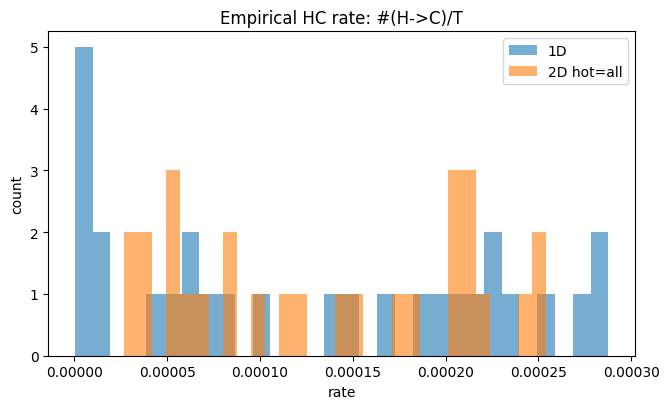

(<Figure size 680x420 with 1 Axes>,
 <Axes: title={'center': 'Empirical HC rate: #(H->C)/T'}, xlabel='rate', ylabel='count'>)

In [19]:
plot_rate_hist_overlay(
    emp_1d_s1, emp_2d_all_s1,
    direction="hc", per_tick=True, chain="mean",
    label1="1D", label2="2D hot=all",
    title="Empirical HC rate: #(H->C)/T"
)


In [20]:
from dreamingnetz.pt_tau import  load_compare

In [21]:
comp = load_compare(ROOT/"analysis"/"tau_comp_1d_vs_2d_b0.pkl.gz")

In [34]:
Δ_τ=np.median(np.mean(comp.right.m_mu0.tau_geyer,axis=1)[:,-3:],axis=1)/np.median(np.mean(comp.left.m_mu0.tau_geyer,axis=1)[:,-3:],axis=1)

In [32]:
tauR = np.mean(comp.right.m_mu0.tau_geyer, axis=1)[:, -2:]   # (n_dis, 2)
tauL = np.mean(comp.left .m_mu0.tau_geyer, axis=1)[:, -2:]   # (n_dis, 2)

gR = 10**(np.mean(np.log10(tauR), axis=1))   # (n_dis,)
gL = 10**(np.mean(np.log10(tauL), axis=1))   # (n_dis,)

Δ_τ = gR / gL

In [28]:
# pick which rate you want
key = "k_hc_per_tick"   # or "k_ch_per_tick"

k2 = np.nanmean(emp_2d_b0_s1[key], axis=1)   # (n_dis,) average over chains
k1 = np.nanmean(emp_1d_s1[key],     axis=1)  # (n_dis,)

m = np.isfinite(k1) & np.isfinite(k2) & (k1 > 0) & (k2 > 0)
Δ_k = np.full_like(k1, np.nan, dtype=float)
Δ_k[m] = k2[m] / k1[m]     # elementwise ratio: 2D / 1D


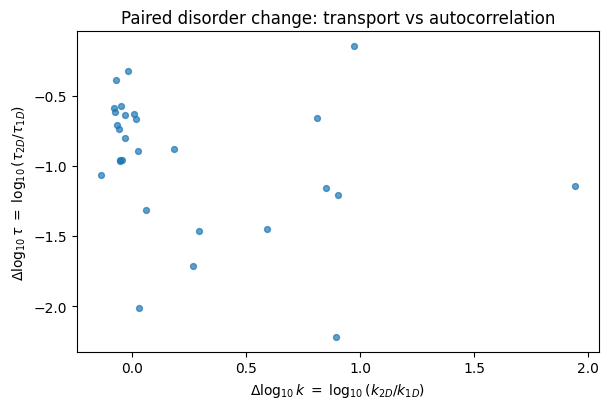

In [35]:
delta_tau = Δ_τ          # = tau_2d / tau_1d   (must be >0)
delta_k   = Δ_k          # = k_2d   / k_1d     (must be >0)

mask = np.isfinite(delta_tau) & np.isfinite(delta_k) & (delta_tau > 0) & (delta_k > 0)

dlog_tau = np.log10(delta_tau[mask])   # <0 means tau got smaller in 2D
dlog_k   = np.log10(delta_k[mask])     # >0 means rate got larger in 2D

# --- Plot 1: does improved transport correlate with reduced tau_int? ---
plt.figure(figsize=(6.2, 4.2))
#plt.axhline(0.0, linestyle="--")
#plt.axvline(0.0, linestyle="--")
plt.scatter(dlog_k, dlog_tau, s=18, alpha=0.7)
plt.xlabel(r"$\Delta \log_{10} k \;=\;\log_{10}(k_{2D}/k_{1D})$")
plt.ylabel(r"$\Delta \log_{10}\tau \;=\;\log_{10}(\tau_{2D}/\tau_{1D})$")
plt.title("Paired disorder change: transport vs autocorrelation")
plt.tight_layout()
plt.show()

In [29]:
Δ_k

array([ 1.96838527,  9.36288288,  1.53050898,  7.97297297,  3.9029799 ,
       87.8018018 ,  0.86265407,  0.87728781,  0.83600805,  7.83908046,
        1.06073628,  0.90500106,  0.88238549,  0.88613944,  1.07578713,
        1.84428639,  0.93283189,  6.46536191,  0.84811612,  0.83923734,
        7.05987   ,  0.96390986,  1.04096224,  0.93526001,  1.01979055,
        1.14751675,  0.72860607,  0.89912686])

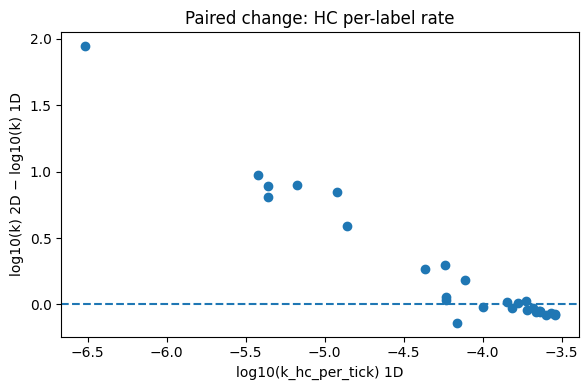

In [14]:
k1 = np.nanmean(emp_1d_s1["k_hc_per_tick"], axis=1)      # (R,)
k2 = np.nanmean(emp_2d_b0_s1["k_hc_per_tick"], axis=1)   # (R,)

m = np.isfinite(k1) & np.isfinite(k2) & (k1>0) & (k2>0)
x = np.log10(k1[m])
d = np.log10(k2[m]) - np.log10(k1[m])

plt.figure(figsize=(6,4))
plt.axhline(0, ls="--")
plt.scatter(x, d)
plt.xlabel("log10(k_hc_per_tick) 1D")
plt.ylabel("log10(k) 2D − log10(k) 1D")
plt.title("Paired change: HC per-label rate")
plt.tight_layout(); plt.show()


In [ ]:
#out1d  = pt2d_roundtrip_medians(I_ts_t0_stack, k_start=k_start_1d, hot_mode="b0", stat="mean", show=False)
#out_b0 = pt2d_roundtrip_medians(I_ts_stack,     k_start=k_start,    hot_mode="b0", stat="mean", show=False)
#out_all= pt2d_roundtrip_medians(I_ts_stack,     k_start=k_start,    hot_mode="all",stat="mean", show=False)


In [ ]:

#fig, axes = compare_roundtrip_times_2x3(out1d, out_b0, out_all, stat="mean")


In [ ]:
#out1d  = pt2d_roundtrip_medians(I_ts_t0_stack, k_start=k_start_1d, hot_mode="b0", stat="median", show=False)
#out_b0 = pt2d_roundtrip_medians(I_ts_stack,     k_start=k_start,    hot_mode="b0", stat="median", show=False)
#out_all= pt2d_roundtrip_medians(I_ts_stack,     k_start=k_start,    hot_mode="all",stat="median", show=False)

#fig, axes = compare_roundtrip_times_2x3(out1d, out_b0, out_all, stat="median")

#  Transition matrix derived plots

In [6]:
import dreamingnetz.ptflow as ptflow

## plots

In [13]:
def plot_theory_A_rate_hist(theory_out, *, direction="hc", per_tick=True, bins=30, logx=True, title=None):
    key = ("k_hc_per_tick" if per_tick else "k_hc") if direction == "hc" else ("k_ch_per_tick" if per_tick else "k_ch")
    x = np.asarray(theory_out[key], float)
    x = x[np.isfinite(x) & (x > 0)]
    if x.size == 0:
        print("Empty data.")
        return

    fig, ax = plt.subplots(figsize=(6.2, 4.0))
    if logx:
        ax.hist(np.log10(x), bins=bins, alpha=0.7)
        ax.set_xlabel("log10(rate)")
    else:
        ax.hist(x, bins=bins, alpha=0.7)
        ax.set_xlabel("rate")
    ax.set_ylabel("count")
    if title is None:
        unit = "per tick" if per_tick else "per step"
        title = f"Theory rate histogram ({direction.upper()}, {unit}, stride={theory_out['stride']})"
    ax.set_title(title)
    plt.tight_layout(); plt.show()


def plot_theory_C_tau_vs_invk(theory_out, *, direction="hc", per_tick=True, title=None):
    if direction == "hc":
        tau = "tau_hc_ticks" if per_tick else "tau_hc"
        k   = "k_hc_per_tick" if per_tick else "k_hc"
    else:
        tau = "tau_ch_ticks" if per_tick else "tau_ch"
        k   = "k_ch_per_tick" if per_tick else "k_ch"

    t = np.asarray(theory_out[tau], float)
    r = np.asarray(theory_out[k], float)
    m = np.isfinite(t) & np.isfinite(r) & (t > 0) & (r > 0)
    t, r = t[m], r[m]
    if t.size == 0:
        print("Empty data.")
        return

    fig, ax = plt.subplots(figsize=(6.2, 4.2))
    ax.plot(1.0/r, t, linestyle="none", marker="o", alpha=0.7)
    ax.set_xscale("log"); ax.set_yscale("log")
    ax.set_xlabel("1 / rate")
    ax.set_ylabel("mean MFPT")
    if title is None:
        unit = "ticks" if per_tick else "steps"
        title = f"Theory MFPT vs 1/rate ({direction.upper()}, {unit}, stride={theory_out['stride']})"
    ax.set_title(title)
    ax.grid(True, which="both", alpha=0.2)
    plt.tight_layout(); plt.show()

### empirical

In [15]:
# 1D
N1 = I_ts_t0_stack.shape[-1]
emp_1d_s1 = empirical_passage_stats(I_ts_t0_stack, hot_idx=[0], cold_idx=[N1-1], stride=1, stat="mean")

# 2D b0 vs all-hot
cold_b0 = [int(k_start[1]-1)]


emp_2d_b0_s1  = empirical_passage_stats(I_ts_stack, hot_idx=[0],              cold_idx=cold_b0, stride=1, stat="mean")
emp_2d_all_s1 = empirical_passage_stats(I_ts_stack, hot_idx=k_start[:-1],     cold_idx=cold_b0, stride=1, stat="mean")

In [ ]:
plot_rate_hist_overlay(
    emp_1d_s1, emp_2d_b0_s1,
    direction="hc", per_tick=True, chain="mean",
    label1="1D empirical", label2="2D b0 empirical",
    title="Empirical HC rate (per tick, stride=1): 1D vs 2D(b0)"
)


## Flow Based

In [7]:
### this is very dumb on my part:start
from typing import Optional, Tuple
from numpy.typing import NDArray
from dataclasses import dataclass, field
@dataclass(frozen=True, slots=True)
class SysLite:
    # inputs
    t_grid: NDArray[np.float64]                               # (B,)
    beta_by_t: Tuple[NDArray[np.float64], ...]                # len B, each (K_b,)
    edge_list: Optional[NDArray[np.int64]] = None             # (E,2) in [0,R), optional

    # derived
    B: int = field(init=False)
    K: NDArray[np.int64] = field(init=False)                  # (B,)
    k_start: NDArray[np.int64] = field(init=False)            # (B+1,)
    R: int = field(init=False)
    beta: NDArray[np.float64] = field(init=False)             # (R,)
    b_of_r: NDArray[np.int64] = field(init=False)             # (R,)

    def __post_init__(self):
        t = np.ascontiguousarray(np.asarray(self.t_grid, dtype=np.float64))
        if t.ndim != 1 or t.size == 0:
            raise ValueError("t_grid must be 1D and non-empty")
        B = int(t.size)

        if len(self.beta_by_t) != B:
            raise ValueError(f"beta_by_t must have length B={B}")

        beta_norm = []
        K = np.empty(B, dtype=np.int64)
        for b in range(B):
            bet = np.ascontiguousarray(np.asarray(self.beta_by_t[b], dtype=np.float64))
            if bet.ndim != 1:
                raise ValueError(f"beta_by_t[{b}] must be 1D")
            beta_norm.append(bet)
            K[b] = bet.size

        k_start = np.empty(B + 1, dtype=np.int64)
        k_start[0] = 0
        np.cumsum(K, out=k_start[1:])
        R = int(k_start[-1])

        beta_flat = np.empty(R, dtype=np.float64)
        for b in range(B):
            beta_flat[k_start[b]:k_start[b+1]] = beta_norm[b]

        b_of_r = np.repeat(np.arange(B, dtype=np.int64), K)

        # optional edge list validation
        e = self.edge_list
        if e is not None:
            e = np.ascontiguousarray(np.asarray(e, dtype=np.int64))
            if e.ndim != 2 or e.shape[1] != 2:
                raise ValueError("edge_list must have shape (E,2)")
            if np.any((e < 0) | (e >= R)):
                raise ValueError("edge_list contains node indices outside [0,R)")
            object.__setattr__(self, "edge_list", e)

        object.__setattr__(self, "t_grid", t)
        object.__setattr__(self, "B", B)
        object.__setattr__(self, "beta_by_t", tuple(beta_norm))
        object.__setattr__(self, "K", K)
        object.__setattr__(self, "k_start", k_start)
        object.__setattr__(self, "R", R)
        object.__setattr__(self, "beta", np.ascontiguousarray(beta_flat))
        object.__setattr__(self, "b_of_r", np.ascontiguousarray(b_of_r))

from dreamingnetz.beta_ladder_search import build_edge_list_two_sided_nearest_beta

t_grid = np.array([0, 0.05, 0.11, 0.25, 0.50], dtype=np.float64)


# compute k_start without your full SysConfig
tmp = SysLite(t_grid=t_grid, beta_by_t=beta_by_t)

edge_list = build_edge_list_two_sided_nearest_beta(beta_by_t, tmp.k_start)

sys_2d = SysLite(t_grid=t_grid, beta_by_t=beta_by_t, edge_list=edge_list)




class Sys1D:
    def __init__(self, beta):
        self.beta = np.asarray(beta, float)

#sys1d = Sys1D(betas_t0)
### this is very dumb on my part:end

In [8]:
def plot_2d_current_streamlines(
    meta: ptflow.PTMeta, 
    J_macro: np.ndarray, 
    *, 
    title: str = "Net Current Streamlines",
    min_flux: float = 1e-10,
    cmap_name: str = 'magma_r',
    transpose_axes: bool = True  # <--- NEW SWITCH
):
    """
    Visualizes the "Net Current" J as a 2D vector field.
    transpose_axes=False: X=Temp(k), Y=Replica(b) (Standard)
    transpose_axes=True:  X=Replica(b), Y=Temp(k) (Portrait Mode)
    """
    B = meta.B
    
    # 1. Determine Grid Dimensions
    max_k = 0
    node_coords = {} 

    for b in range(B):
        r_start = int(meta.k_start[b])
        r_end = int(meta.k_start[b+1])
        len_k = r_end - r_start
        max_k = max(max_k, len_k)

    for b in range(B):
        r_start = int(meta.k_start[b])
        r_end = int(meta.k_start[b+1])
        len_k = r_end - r_start
        
        for k_idx in range(len_k):
            u = r_start + k_idx

            d= max_k-len_k

            if (d>0 and k_idx>2): 
                node_coords[u] = (k_idx+d, b)
            else:
                node_coords[u] = (k_idx, b)

    # 2. Calculate Physical Vectors (Flux in k, Flux in b)
    # U_phys = Flux along k (Horizontal in standard plot)
    # V_phys = Flux along b (Vertical in standard plot)
    U_phys = np.zeros((B, max_k)) 
    V_phys = np.zeros((B, max_k))
    
    for u, (kx_u, ky_u) in node_coords.items():
        vec_k = 0.0 # Physical k-flux
        vec_b = 0.0 # Physical b-flux
        
        targets = np.where(np.abs(J_macro[u]) > 0)[0]
        
        for v in targets:
            flux = J_macro[u, v]
            if v not in node_coords: continue
            
            kx_v, ky_v = node_coords[v]
            dk = kx_v - kx_u
            db = ky_v - ky_u
            
            vec_k += flux * dk
            vec_b += flux * db
            
        U_phys[ky_u, kx_u] = vec_k
        V_phys[ky_u, kx_u] = vec_b

    # 3. Handle Axis Transposition
    if transpose_axes:
        # X-axis = Replica (b) [Size B]
        # Y-axis = Temp (k)    [Size max_k]
        X = np.arange(B)
        Y = np.arange(max_k)
        
        # Transpose matrices so shape matches (Y, X) -> (max_k, B)
        # And SWAP vector components:
        # Screen Horizontal (U) comes from Physical b-flux (V_phys)
        # Screen Vertical (V) comes from Physical k-flux (U_phys)
        U_plot = V_phys.T
        V_plot = U_phys.T
        
        xlabel = "Replica Row b"
        ylabel = "Temperature Index k"
        
    else:
        # Standard Landscape
        # X-axis = Temp (k)
        # Y-axis = Replica (b)
        X = np.arange(max_k)
        Y = np.arange(B)
        
        U_plot = U_phys
        V_plot = V_phys
        
        xlabel = "Temperature Index k"
        ylabel = "Replica Row b"

    MAG = np.sqrt(U_plot**2 + V_plot**2)
    mask = MAG > min_flux
    
    # A. Calculate Unit Directions
    # (Avoid divide by zero warnings using the mask)
    U_unit = np.zeros_like(U_plot)
    V_unit = np.zeros_like(V_plot)
    
    U_unit[mask] = U_plot[mask] / MAG[mask]
    V_unit[mask] = V_plot[mask] / MAG[mask]
    
    # B. Define "Display Length"
    # We compress the range. Instead of Length = Magnitude, 
    # we use Length = Magnitude^alpha.
    # alpha=0.3 is usually the "magic number" for high dynamic range flows.
    # It allows you to see 1e-6 and 1e-2 on the same plot.
    length_power = 0.3  
    
    # Normalize MAG to 0..1 range first for stable scaling
    max_mag = np.nanmax(MAG)
    if max_mag == 0: max_mag = 1.0
    
    # This creates lengths between 0.0 and 1.0, heavily boosting small values
    LEN_display = (MAG / max_mag) ** length_power
    
    # C. Reconstruct "Visual" Vectors
    # These vectors have "fake" lengths for display, but correct directions
    U_visual = U_unit * LEN_display
    V_visual = V_unit * LEN_display
    
    # Apply Mask
    U_visual[~mask] = np.nan
    V_visual[~mask] = np.nan

    # 5. Plotting
    # -------------------------------------------------
    if transpose_axes:
        fig_w, fig_h = 5 + 0.6*B, 8 
    else:
        fig_w, fig_h = 10, 5 + 0.5*B

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    
    norm = mcolors.PowerNorm(vmin=max(min_flux, MAG[mask].min()), vmax=max_mag, gamma=1)
    
    q = ax.quiver(X, Y, U_visual, V_visual, MAG, 
                  cmap=cmap_name, norm=norm,
                  pivot='mid',
                  
                  # --- THE FIX ---
                  angles='uv',          # Arrow direction is relative to Screen Pixels (not Data Grid)
                  scale_units='width',  # Arrow length is relative to Plot Width
                  scale=7,             # Inverse Scale: Higher number = Shorter arrows. Tune this!
                  
                  headwidth=4, headlength=5, width=0.005)

    cbar = plt.colorbar(q, ax=ax)
    scale_label = f" (x{flux_scale_factor:g})" if 'flux_scale_factor' in locals() and flux_scale_factor != 1 else ""
    cbar.set_label(f'Net Flux Magnitude{scale_label}')
    
    ax.set_xticks(X)
    ax.set_yticks(Y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, linestyle=':', alpha=0.3)
    ax.scatter(np.tile(X, len(Y)), np.repeat(Y, len(X)), c='gray', s=2, alpha=0.6)
    plt.xlim()
    
    plt.tight_layout()
    plt.show()

NameError: name 'mcolors' is not defined

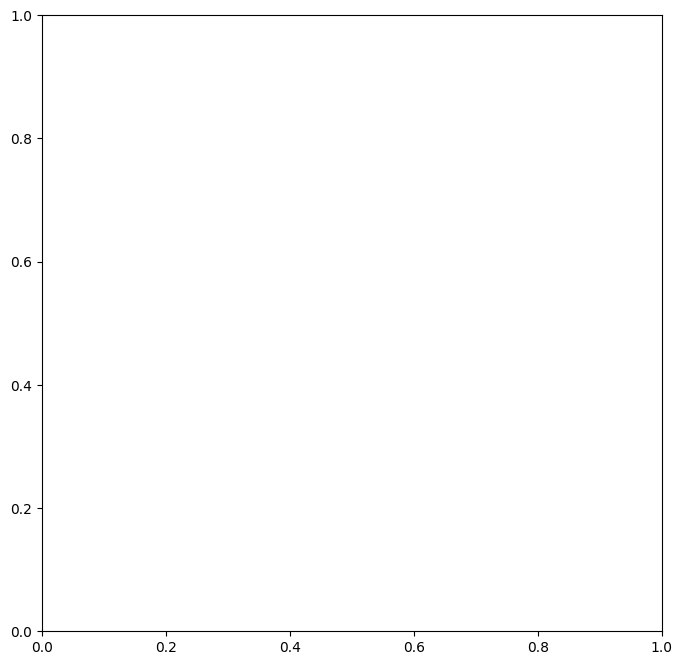

In [ ]:
meta = ptflow.meta_from_sys(sys_2d)

# pick the same ends logic you used before (e.g. C0_C4 with invert=False)
ends = ptflow.get_flexible_ends(meta, mode="C0_Dual", b_cold=0, b_aux=4, k_top=1, invert=True)

out2s = ptflow.analyze_I_stack_tpt_macro(
    I_ts_stack, sys_2d,
    ends=ends,
    burn_in=0.0,
    stride=3,
    average_offsets=True,
    chunk=4000,
    store_f=False
)

rid = int(out2s["rid"][0])          # or any disorder id you want
J_macro = out2s["per_rid"][rid]["J"]


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def _node_coords_from_meta(meta):
    B = meta.B
    max_k = 0
    for b in range(B):
        r0, r1 = int(meta.k_start[b]), int(meta.k_start[b+1])
        max_k = max(max_k, r1 - r0)

    node_coords = {}
    for b in range(B):
        r0, r1 = int(meta.k_start[b]), int(meta.k_start[b+1])
        len_k = r1 - r0
        d = max_k - len_k
        for k_idx in range(len_k):
            u = r0 + k_idx
            if (d > 0 and k_idx > 2):
                node_coords[u] = (k_idx + d, b)
            else:
                node_coords[u] = (k_idx, b)
    return node_coords, max_k


def quiver_field_from_J(meta, J_macro, *, transpose_axes=True, min_edge_flux=0.0):
    """
    Convert J (N,N) into a quiver field on the ragged (b,k) grid.
    Returns U_plot, V_plot, MAG and the X,Y grid used in plotting.
    """
    node_coords, max_k = _node_coords_from_meta(meta)
    B = meta.B
    N = J_macro.shape[0]

    U_phys = np.zeros((B, max_k), dtype=np.float64)  # along k
    V_phys = np.zeros((B, max_k), dtype=np.float64)  # along b

    J = np.asarray(J_macro, dtype=np.float64)

    for u, (kx_u, ky_u) in node_coords.items():
        row = J[u]
        if min_edge_flux > 0:
            targets = np.flatnonzero(np.abs(row) > min_edge_flux)
        else:
            targets = np.flatnonzero(row != 0.0)

        vec_k = 0.0
        vec_b = 0.0
        for v in targets:
            if v not in node_coords:
                continue
            flux = row[v]
            kx_v, ky_v = node_coords[v]
            dk = kx_v - kx_u
            db = ky_v - ky_u
            vec_k += flux * dk
            vec_b += flux * db

        U_phys[ky_u, kx_u] = vec_k
        V_phys[ky_u, kx_u] = vec_b

    if transpose_axes:
        # X=b, Y=k, and swap components to match screen axes
        X = np.arange(B)
        Y = np.arange(max_k)
        U_plot = V_phys.T
        V_plot = U_phys.T
        xlabel = "Replica Row b"
        ylabel = "Temperature Index k"
    else:
        X = np.arange(max_k)
        Y = np.arange(B)
        U_plot = U_phys
        V_plot = V_phys
        xlabel = "Temperature Index k"
        ylabel = "Replica Row b"

    MAG = np.sqrt(U_plot**2 + V_plot**2)
    return dict(X=X, Y=Y, U=U_plot, V=V_plot, MAG=MAG, xlabel=xlabel, ylabel=ylabel)


def average_quiver_over_disorders(meta, out2s, *, rids=None, transpose_axes=True, min_edge_flux=0.0):
    """
    Average *after* mapping J->(U,V). Returns:
      - U_mean, V_mean : mean vector field (direction + cancellations)
      - MAG_mean_abs   : mean magnitude per cell (typical throughput)
      - coherence      : |mean vector| / mean magnitude  in [0,1]
    """
    if rids is None:
        rids = sorted(out2s["per_rid"].keys())

    U_sum = V_sum = MAGabs_sum = None
    n = 0

    for rid in rids:
        J = out2s["per_rid"][int(rid)]["J"]
        F = quiver_field_from_J(meta, J, transpose_axes=transpose_axes, min_edge_flux=min_edge_flux)
        U, V = F["U"], F["V"]
        mag = np.sqrt(U**2 + V**2)

        if U_sum is None:
            U_sum = np.zeros_like(U)
            V_sum = np.zeros_like(V)
            MAGabs_sum = np.zeros_like(mag)

        U_sum += U
        V_sum += V
        MAGabs_sum += mag
        n += 1

    U_mean = U_sum / max(1, n)
    V_mean = V_sum / max(1, n)
    MAG_mean_abs = MAGabs_sum / max(1, n)

    MAG_mean_vec = np.sqrt(U_mean**2 + V_mean**2)
    coherence = np.zeros_like(MAG_mean_vec)
    m = MAG_mean_abs > 0
    coherence[m] = MAG_mean_vec[m] / MAG_mean_abs[m]

    # reuse labels/grid from last F
    F_out = dict(F)
    F_out.update(U=U_mean, V=V_mean, MAG=MAG_mean_abs, coherence=coherence, n=n)
    return F_out


def plot_quiver_field(field, *, title="Mean net current (averaged in quiver space)",
                      min_flux=1e-10, cmap_name="magma_r", length_power=0.3):
    """
    Plot a quiver field dict like returned by average_quiver_over_disorders().
    Colors by MAG (default: mean magnitude), arrows follow mean direction.
    """
    X, Y = field["X"], field["Y"]
    U_plot, V_plot, MAG = field["U"], field["V"], field["MAG"]

    mask = MAG > min_flux

    U_unit = np.zeros_like(U_plot)
    V_unit = np.zeros_like(V_plot)
    U_unit[mask] = U_plot[mask] / np.sqrt(U_plot[mask]**2 + V_plot[mask]**2)
    V_unit[mask] = V_plot[mask] / np.sqrt(U_plot[mask]**2 + V_plot[mask]**2)

    max_mag = float(np.nanmax(MAG[mask])) if np.any(mask) else 1.0
    LEN_display = (MAG / max_mag) ** length_power

    U_visual = U_unit * LEN_display
    V_visual = V_unit * LEN_display
    U_visual[~mask] = np.nan
    V_visual[~mask] = np.nan

    fig_w, fig_h = (5 + 0.6*len(X), 8) if (len(X) < len(Y)) else (10, 5 + 0.5*len(Y))
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    vmin = max(min_flux, float(np.nanmin(MAG[mask]))) if np.any(mask) else min_flux
    norm = mcolors.PowerNorm(vmin=vmin, vmax=max_mag, gamma=1)

    q = ax.quiver(X, Y, U_visual, V_visual, MAG,
                  cmap=cmap_name, norm=norm,
                  pivot="mid",
                  angles="uv",
                  scale_units="width",
                  scale=7,
                  headwidth=4, headlength=5, width=0.005)

    cbar = plt.colorbar(q, ax=ax)
    cbar.set_label("Mean |net flux| magnitude (after quiver mapping)")

    ax.set_xticks(X)
    ax.set_yticks(Y)
    ax.set_xlabel(field["xlabel"])
    ax.set_ylabel(field["ylabel"])
    ax.set_title(title)
    ax.grid(True, linestyle=":", alpha=0.3)

    # show grid points
    ax.scatter(np.tile(X, len(Y)), np.repeat(Y, len(X)), c="gray", s=2, alpha=0.6)

    plt.tight_layout()
    plt.show()
    return fig, ax


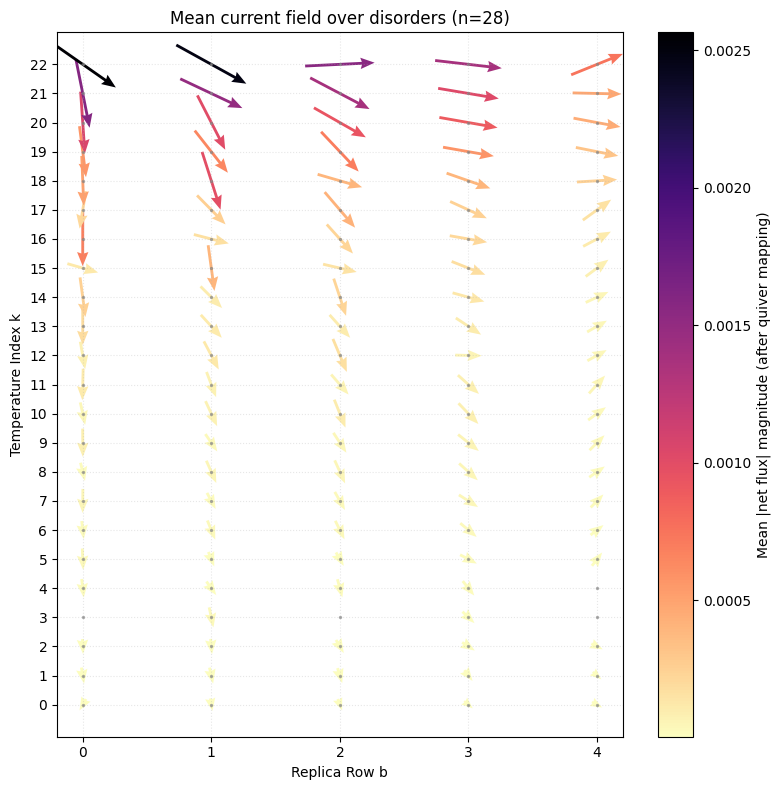

(<Figure size 800x800 with 2 Axes>,
 <Axes: title={'center': 'Mean current field over disorders (n=28)'}, xlabel='Replica Row b', ylabel='Temperature Index k'>)

In [19]:
field = average_quiver_over_disorders(meta, out2s, transpose_axes=True)
plot_quiver_field(field, title=f"Mean current field over disorders (n={field['n']})")


# Other

In [18]:
meta = ptflow.meta_from_sys(sys_2d)

ends_b0  = ptflow.ends_row0(meta, b0=0, hot_k=0, cold_top=1)
ends_all = ptflow.ends_hybrid(meta, b0=0, hot_k=0, cold_top=1)   # hot=k=0 in all rows



theo_2d_b0_s1 = ptflow.analyze_I_stack_theory(I_ts_stack, sys_2d, ends=ends_b0,  stride=1, period=3, burn_in=0.0)
theo_2d_all_s1= ptflow.analyze_I_stack_theory(I_ts_stack, sys_2d, ends=ends_all, stride=1, period=3, burn_in=0.0)

In [19]:
meta1 = ptflow.meta_from_sys(sys1d)              # for 1D, meta.B should be 1 and meta.R=K
N = I_ts_t0_stack.shape[-1]                      # should equal len(betas_t0)
ends1 = ptflow.Ends(
    hot_idx=np.array([0], dtype=np.int64),
    cold_idx=np.array([N-1], dtype=np.int64),
    b0=0,
    row0_boxes=np.arange(N, dtype=np.int64),
)

theo_1d_s1 = ptflow.analyze_I_stack_theory(I_ts_t0_stack, sys1d, ends=ends1, stride=1, period=3, burn_in=0.0)


In [33]:
def empirical_to_per_label(emp, N):
    emp = dict(emp)  # shallow copy
    for key in ("k_hc", "k_ch", "k_hc_per_tick", "k_ch_per_tick"):
        emp[key] = np.asarray(emp[key], float) / float(N)
    return emp

In [32]:
k_start[-1]

np.int64(111)

In [34]:
emp_2d_all_s1 = empirical_to_per_label(emp_2d_all_s1, k_start[-1])

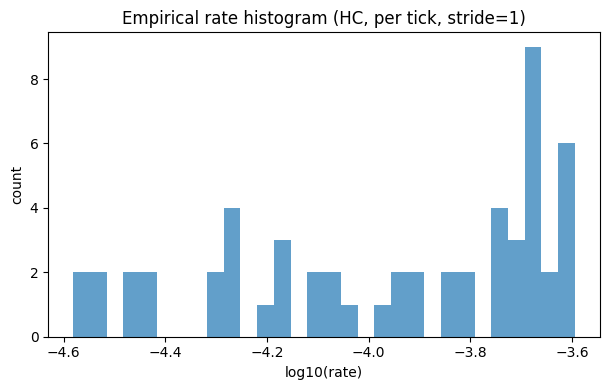

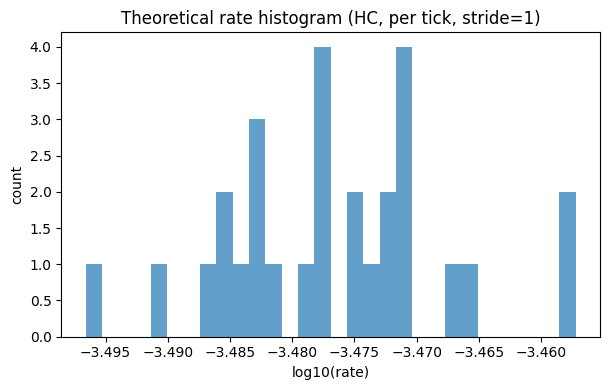

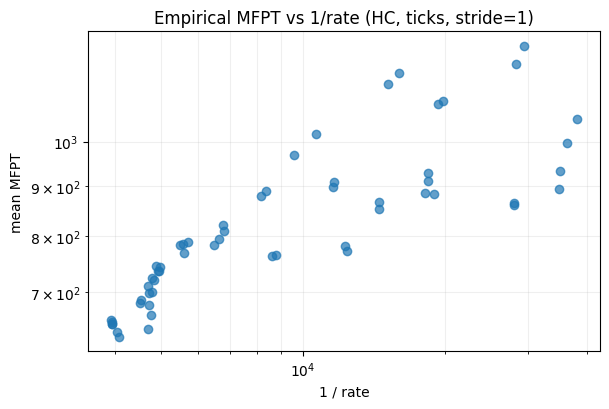

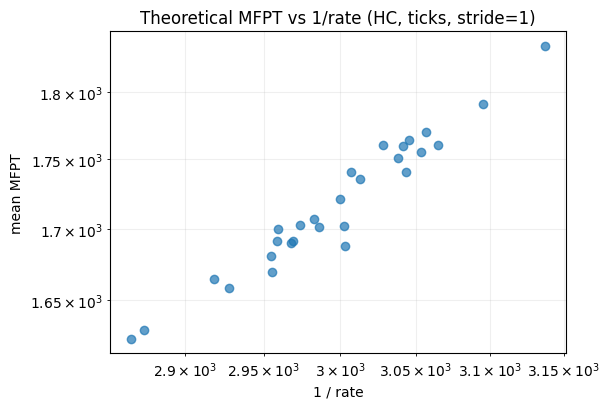

In [35]:
# A: empirical rate histogram
plot_theory_A_rate_hist(emp_2d_all_s1, direction="hc", per_tick=True,
                        title=f"Empirical rate histogram (HC, per tick, stride={emp_2d_all_s1['stride']})")
plot_theory_A_rate_hist(theo_2d_all_s1, direction="hc", per_tick=True,
                        title=f"Theoretical rate histogram (HC, per tick, stride={theo_2d_all_s1['stride']})")

# C: empirical MFPT vs 1/rate
plot_theory_C_tau_vs_invk(emp_2d_all_s1, direction="hc", per_tick=True,
                          title=f"Empirical MFPT vs 1/rate (HC, ticks, stride={emp_2d_all_s1['stride']})")
plot_theory_C_tau_vs_invk(theo_2d_all_s1, direction="hc", per_tick=True,
                          title=f"Theoretical MFPT vs 1/rate (HC, ticks, stride={theo_2d_all_s1['stride']})")

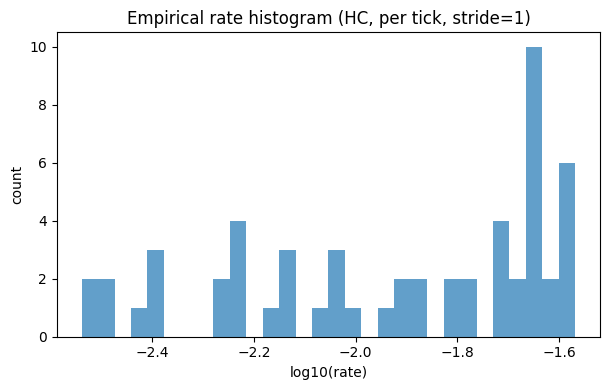

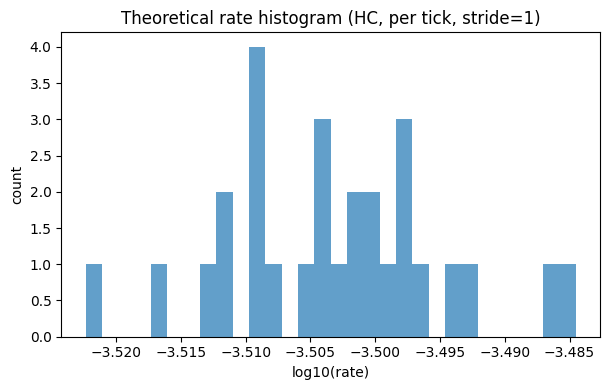

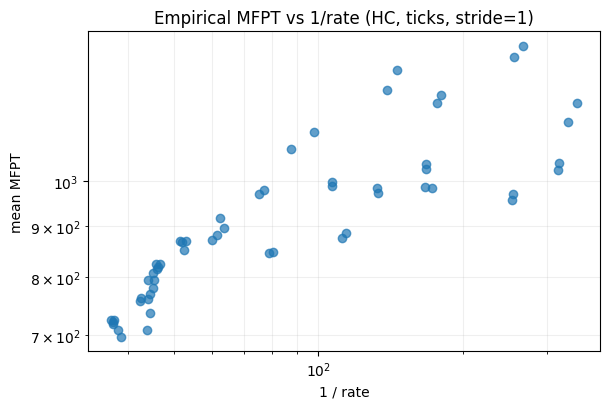

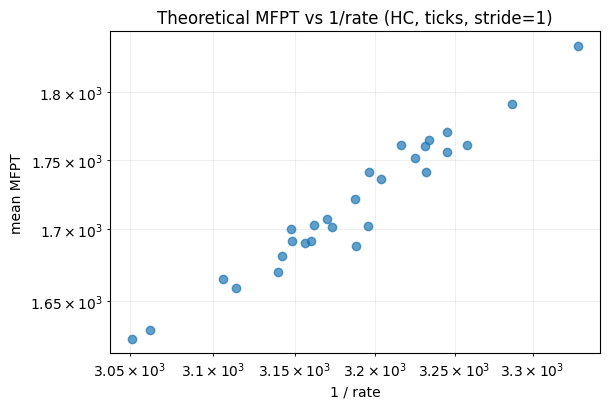

In [23]:
# A: empirical rate histogram
plot_theory_A_rate_hist(emp_2d_b0_s1, direction="hc", per_tick=True,
                        title=f"Empirical rate histogram (HC, per tick, stride={emp_2d_b0_s1['stride']})")
plot_theory_A_rate_hist(theo_2d_b0_s1, direction="hc", per_tick=True,
                        title=f"Theoretical rate histogram (HC, per tick, stride={theo_2d_b0_s1['stride']})")

# C: empirical MFPT vs 1/rate
plot_theory_C_tau_vs_invk(emp_2d_b0_s1, direction="hc", per_tick=True,
                          title=f"Empirical MFPT vs 1/rate (HC, ticks, stride={emp_2d_b0_s1['stride']})")
plot_theory_C_tau_vs_invk(theo_2d_b0_s1, direction="hc", per_tick=True,
                          title=f"Theoretical MFPT vs 1/rate (HC, ticks, stride={theo_2d_b0_s1['stride']})")

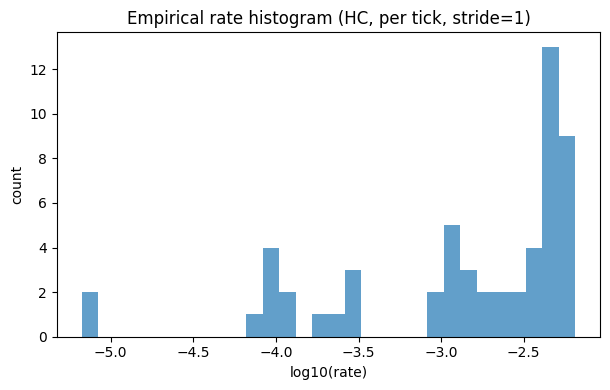

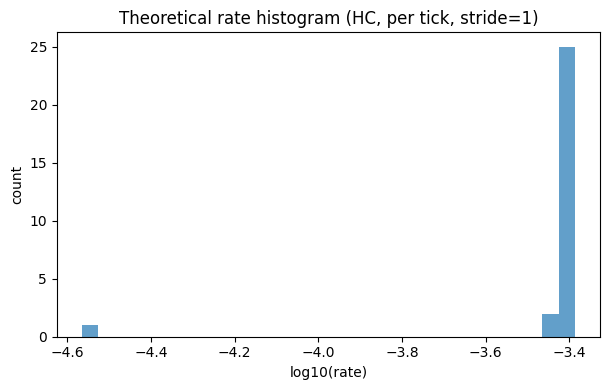

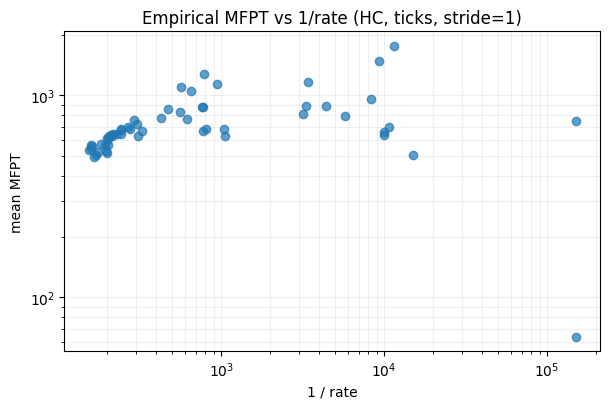

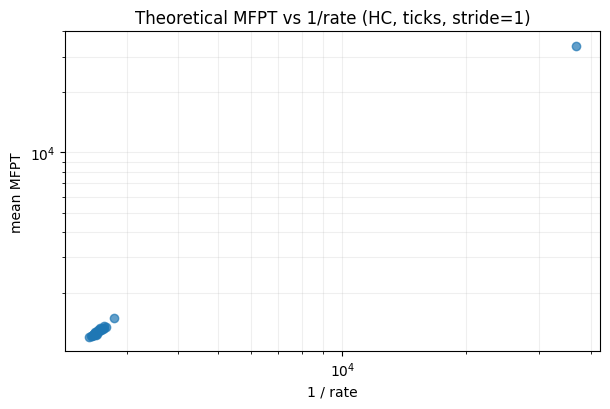

In [22]:
# A: empirical rate histogram
plot_theory_A_rate_hist(emp_1d_s1, direction="hc", per_tick=True,
                        title=f"Empirical rate histogram (HC, per tick, stride={emp_1d_s1['stride']})")
plot_theory_A_rate_hist(theo_1d_s1, direction="hc", per_tick=True,
                        title=f"Theoretical rate histogram (HC, per tick, stride={theo_1d_s1['stride']})")

# C: empirical MFPT vs 1/rate
plot_theory_C_tau_vs_invk(emp_1d_s1, direction="hc", per_tick=True,
                          title=f"Empirical MFPT vs 1/rate (HC, ticks, stride={emp_1d_s1['stride']})")
plot_theory_C_tau_vs_invk(theo_1d_s1, direction="hc", per_tick=True,
                          title=f"Theoretical MFPT vs 1/rate (HC, ticks, stride={theo_1d_s1['stride']})")

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def plot_rate_hist_overlay(
    out1, out2, *,
    direction="hc",
    per_tick=True,
    chain="mean",          # "mean" or int (0/1)
    bins=30,
    logx=False,
    label1="emp 1",
    label2="emp 2",
    title=None,
):
    """
    Overlay two rate histograms (same quantity) on one axes.

    out1/out2: dicts with keys like k_hc_per_tick or k_hc (empirical or theory-style outputs)
    direction: "hc" or "ch"
    per_tick: True -> use *_per_tick keys
    chain: for (R,2) arrays, average chains or pick chain index
    """

    key = ("k_hc_per_tick" if per_tick else "k_hc") if direction == "hc" else ("k_ch_per_tick" if per_tick else "k_ch")

    def _extract(out):
        x = np.asarray(out[key], float)
        if x.ndim == 2:
            x = np.nanmean(x, axis=1) if chain == "mean" else x[:, int(chain)]
        x = x[np.isfinite(x) & (x > 0)]
        return x

    x1 = _extract(out1)
    x2 = _extract(out2)
    if x1.size == 0 or x2.size == 0:
        print("Empty data.")
        return

    fig, ax = plt.subplots(figsize=(6.8, 4.2))
    if logx:
        ax.hist(np.log10(x1), bins=bins, alpha=0.6, label=label1)
        ax.hist(np.log10(x2), bins=bins, alpha=0.6, label=label2)
        ax.set_xlabel("log10(rate)")
    else:
        ax.hist(x1, bins=bins, alpha=0.6, label=label1)
        ax.hist(x2, bins=bins, alpha=0.6, label=label2)
        ax.set_xlabel("rate")

    ax.set_ylabel("count")
    ax.legend()

    if title is None:
        unit = "per tick" if per_tick else "per step"
        s1 = out1.get("stride", "?")
        s2 = out2.get("stride", "?")
        title = f"Rate histogram overlay ({direction.upper()}, {unit}; strides {s1} vs {s2})"
    ax.set_title(title)

    plt.tight_layout()
    plt.show()
    return fig, ax


In [22]:
plot_rate_hist_overlay(
    theo_1d_s1, theo_2d_b0_s1,
    direction="hc", per_tick=True, chain="mean",
    label1="1D empirical", label2="2D b0 empirical",
    title="Empirical HC rate (per tick, stride=1): 1D vs 2D(b0)"
)


NameError: name 'theo_1d_s1' is not defined

In [ ]:
plot_theory_A_rate_hist(theo_1d, direction="hc", per_tick=True)
plot_theory_C_tau_vs_invk(theo_2d_b0, direction="hc", per_tick=True)


In [25]:
emp_2d_b0_s3  = empirical_passage_stats(I_ts_stack, hot_idx=[0],              cold_idx=cold_b0, stride=3, stat="mean")
emp_2d_all_s3 = empirical_passage_stats(I_ts_stack, hot_idx=k_start[:-1],     cold_idx=cold_b0, stride=3, stat="mean")

In [26]:
emp_1d_s3 = empirical_passage_stats(I_ts_t0_stack, hot_idx=[0], cold_idx=[N1-1], stride=3, stat="mean")

In [27]:
theo_2d_b0_s3 = ptflow.analyze_I_stack_theory(I_ts_stack, sys_2d, ends=ends_b0,  stride=3, period=3, burn_in=0.0)
theo_2d_all_s3= ptflow.analyze_I_stack_theory(I_ts_stack, sys_2d, ends=ends_all, stride=3, period=3, burn_in=0.0)

In [28]:
theo_1d_s3 = ptflow.analyze_I_stack_theory(I_ts_t0_stack, sys1d, ends=ends1, stride=3, period=3, burn_in=0.0)

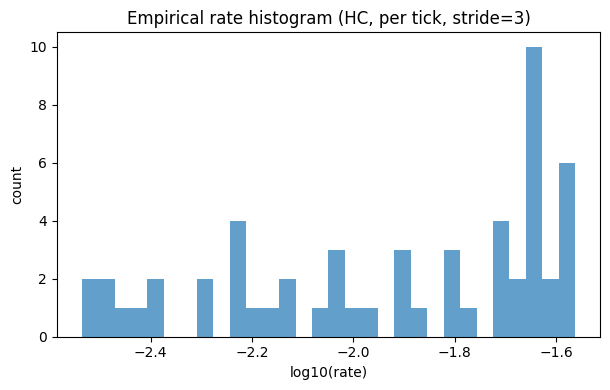

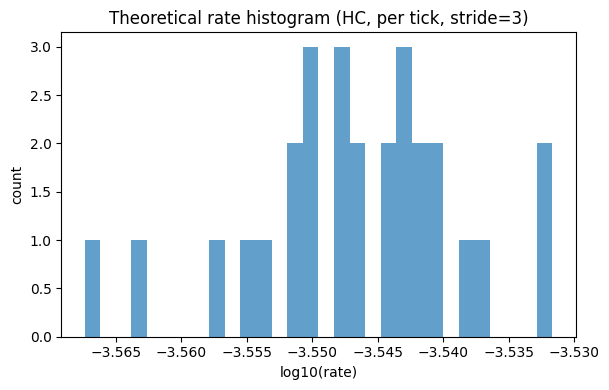

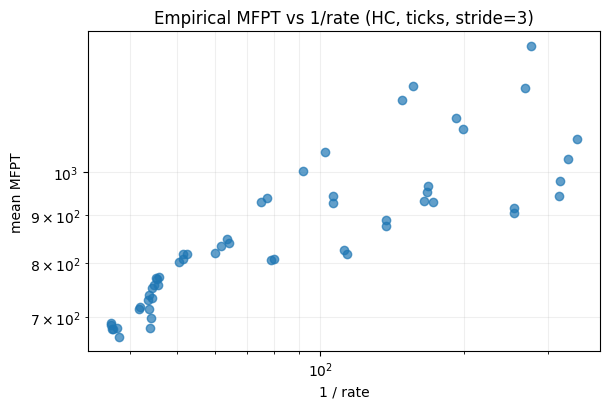

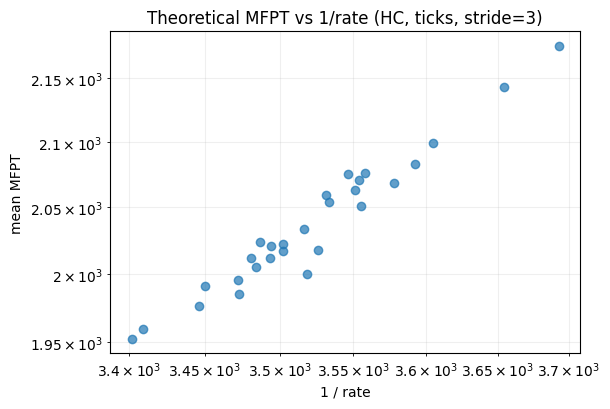

In [31]:
# A: empirical rate histogram
plot_theory_A_rate_hist(emp_2d_all_s3, direction="hc", per_tick=True,
                        title=f"Empirical rate histogram (HC, per tick, stride={emp_2d_all_s3['stride']})")
plot_theory_A_rate_hist(theo_2d_all_s3, direction="hc", per_tick=True,
                        title=f"Theoretical rate histogram (HC, per tick, stride={theo_2d_all_s3['stride']})")

# C: empirical MFPT vs 1/rate
plot_theory_C_tau_vs_invk(emp_2d_all_s3, direction="hc", per_tick=True,
                          title=f"Empirical MFPT vs 1/rate (HC, ticks, stride={emp_2d_all_s3['stride']})")
plot_theory_C_tau_vs_invk(theo_2d_all_s3, direction="hc", per_tick=True,
                          title=f"Theoretical MFPT vs 1/rate (HC, ticks, stride={theo_2d_all_s3['stride']})")

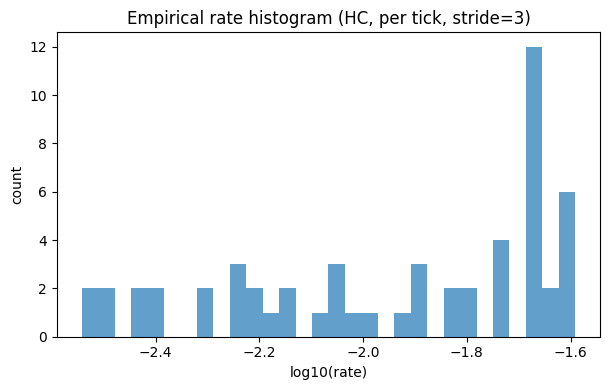

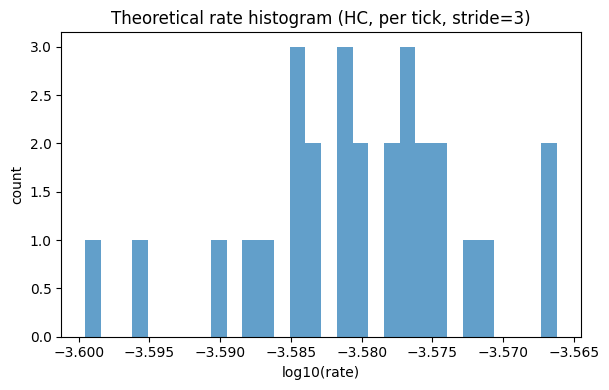

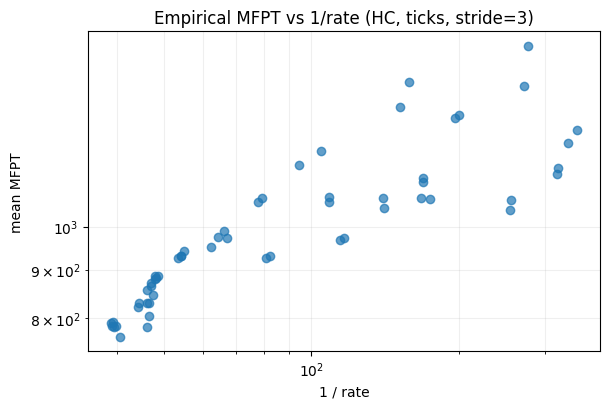

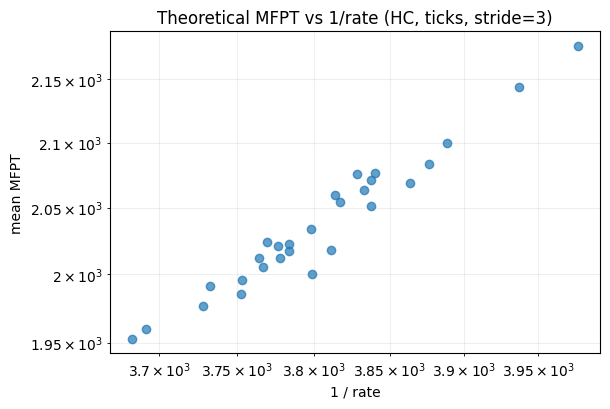

In [30]:
# A: empirical rate histogram
plot_theory_A_rate_hist(emp_2d_b0_s3, direction="hc", per_tick=True,
                        title=f"Empirical rate histogram (HC, per tick, stride={emp_2d_b0_s3['stride']})")
plot_theory_A_rate_hist(theo_2d_b0_s3, direction="hc", per_tick=True,
                        title=f"Theoretical rate histogram (HC, per tick, stride={theo_2d_b0_s3['stride']})")

# C: empirical MFPT vs 1/rate
plot_theory_C_tau_vs_invk(emp_2d_b0_s3, direction="hc", per_tick=True,
                          title=f"Empirical MFPT vs 1/rate (HC, ticks, stride={emp_2d_b0_s3['stride']})")
plot_theory_C_tau_vs_invk(theo_2d_b0_s3, direction="hc", per_tick=True,
                          title=f"Theoretical MFPT vs 1/rate (HC, ticks, stride={theo_2d_b0_s3['stride']})")

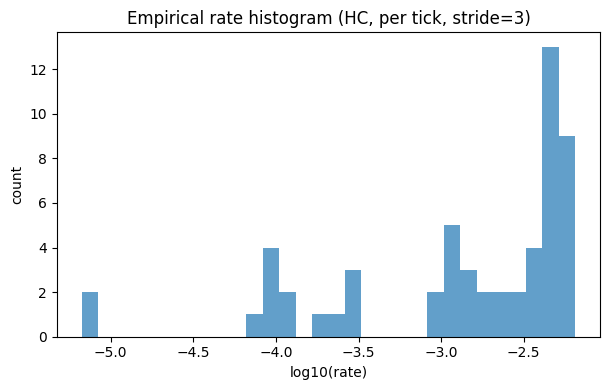

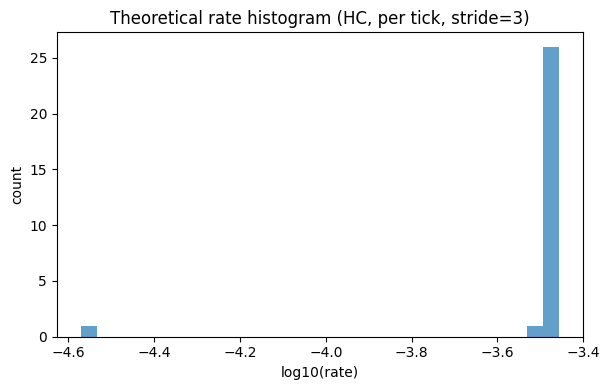

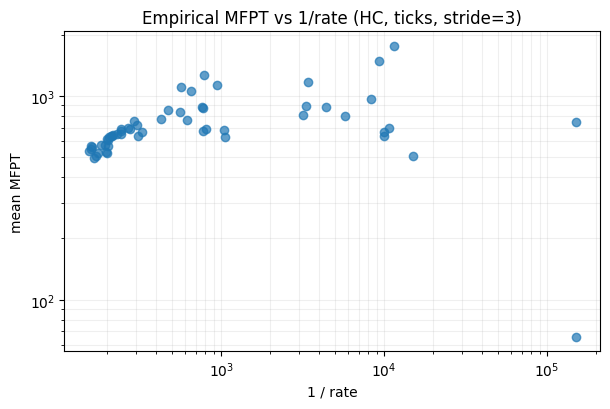

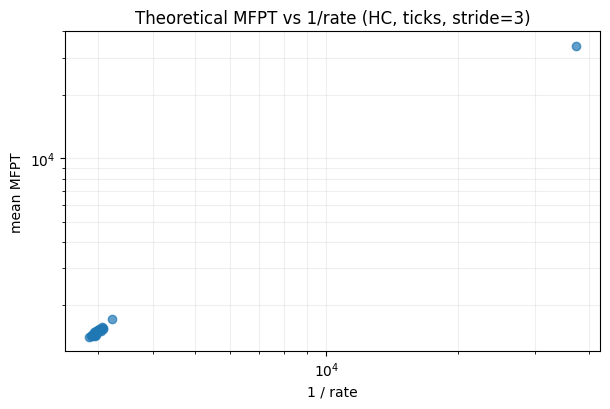

In [29]:
# A: empirical rate histogram
plot_theory_A_rate_hist(emp_1d_s3, direction="hc", per_tick=True,
                        title=f"Empirical rate histogram (HC, per tick, stride={emp_1d_s3['stride']})")
plot_theory_A_rate_hist(theo_1d_s3, direction="hc", per_tick=True,
                        title=f"Theoretical rate histogram (HC, per tick, stride={theo_1d_s3['stride']})")

# C: empirical MFPT vs 1/rate
plot_theory_C_tau_vs_invk(emp_1d_s3, direction="hc", per_tick=True,
                          title=f"Empirical MFPT vs 1/rate (HC, ticks, stride={emp_1d_s3['stride']})")
plot_theory_C_tau_vs_invk(theo_1d_s3, direction="hc", per_tick=True,
                          title=f"Theoretical MFPT vs 1/rate (HC, ticks, stride={theo_1d_s3['stride']})")